In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
import os
from sklearn.decomposition import PCA
from google.colab import drive

plt.rcParams.update({
    "figure.figsize": (3.75, 3.0),
    "font.size": 12,
    "font.family": "serif",
    "axes.grid": False,
    "savefig.dpi": 300,
    "savefig.format": "pdf"
})

def finalize_plot(filename):
    plt.tight_layout()
    plt.savefig(f"{filename}.pdf")
    plt.show()

drive.mount('/content/drive')

file_id = '1F6b961eijthkGNWuA217IqlzwHM9k_4a'
file_path = 'data.csv'
if not os.path.exists(file_path):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

df = pd.read_csv(file_path, dtype={'userId': np.int32, 'movieId': np.int32, 'rating': np.float32})

u_unique, u_map = np.unique(df['userId'], return_inverse=True)
m_unique, m_map = np.unique(df['movieId'], return_inverse=True)
M, N = len(u_unique), len(m_unique)

num_genres = 20
np.random.seed(42)
F = np.random.randint(0, 2, (N, num_genres)).astype(np.float32)

data = np.column_stack((u_map.astype(np.int32), m_map.astype(np.int32), df['rating'].values.astype(np.float32)))
msk = np.random.rand(len(data)) < 0.8
train_data, test_data = data[msk], data[~msk]

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1F6b961eijthkGNWuA217IqlzwHM9k_4a
From (redirected): https://drive.google.com/uc?id=1F6b961eijthkGNWuA217IqlzwHM9k_4a&confirm=t&uuid=9f393fa5-5e14-4849-9496-c4ed3f4efc48
To: /content/data.csv
100%|██████████| 877M/877M [00:07<00:00, 119MB/s]


In [ ]:
def create_index(data, col, size):
    sorted_data = data[data[:, col].argsort()]
    keys = sorted_data[:, col].astype(np.int32)
    idx = np.where(np.diff(keys) != 0)[0] + 1
    split_data = np.split(sorted_data, idx)

    full_index = [np.array([]) for _ in range(size)]
    for arr in split_data:
        if arr.size > 0:
            full_index[int(arr[0, col])] = arr
    return full_index

train_by_user = create_index(train_data, 0, M)
train_by_movie = create_index(train_data, 1, N)

print(f"Data Loaded: {M} users, {N} movies. Ready for training.")

Data Loaded: 200948 users, 84432 movies. Ready for training.


In [ ]:
K, lambda_reg, iters = 10, 0.1, 20
global_mean = np.mean(train_data[:, 2])

def train_hierarchical_als():
    U = np.random.normal(0, 0.01, (M, K)).astype(np.float32)
    V = np.random.normal(0, 0.01, (N, K)).astype(np.float32)
    theta = np.random.normal(0, 0.01, (num_genres, K)).astype(np.float32)

    t_rmse_list, v_rmse_list = [], []
    I_K = np.eye(K, dtype=np.float32)

    for epoch in range(iters):
        # Update Users
        for u in range(M):
            items = train_by_user[u]
            if items.size == 0: continue
            v_i = V[items[:, 1].astype(int)]
            A = v_i.T @ v_i + lambda_reg * I_K
            b = v_i.T @ (items[:, 2] - global_mean)
            U[u] = np.linalg.solve(A, b)

        # Update Movies with genre prior
        F_theta = (F @ theta).astype(np.float32)
        for m in range(N):
            items = train_by_movie[m]
            if items.size == 0:
                V[m] = F_theta[m]
                continue
            u_u = U[items[:, 0].astype(int)]
            A = u_u.T @ u_u + lambda_reg * I_K
            b = u_u.T @ (items[:, 2] - global_mean) + (lambda_reg * F_theta[m])
            V[m] = np.linalg.solve(A, b)

        # Update Feature Weights
        A_theta = F.T @ F + lambda_reg * np.eye(num_genres, dtype=np.float32)
        b_theta = F.T @ V
        theta = np.linalg.solve(A_theta, b_theta)

        # Vectorized scoring
        tr_p = global_mean + np.sum(U[train_data[:, 0].astype(int)] * V[train_data[:, 1].astype(int)], axis=1)
        te_p = global_mean + np.sum(U[test_data[:, 0].astype(int)] * V[test_data[:, 1].astype(int)], axis=1)

        t_rmse_list.append(np.sqrt(np.mean((train_data[:, 2] - tr_p)**2)))
        v_rmse_list.append(np.sqrt(np.mean((test_data[:, 2] - te_p)**2)))

        print(f"Epoch {epoch+1:2d} | Train RMSE: {t_rmse_list[-1]:.4f} | Test RMSE: {v_rmse_list[-1]:.4f}")

    return U, V, theta, t_rmse_list, v_rmse_list

U, V, theta, t_rmse, v_rmse = train_hierarchical_als()

Epoch  1 | Train RMSE: 0.9722 | Test RMSE: 1.0469
Epoch  2 | Train RMSE: 0.7678 | Test RMSE: 0.8544
Epoch  3 | Train RMSE: 0.7371 | Test RMSE: 0.8261
Epoch  4 | Train RMSE: 0.7245 | Test RMSE: 0.8147
Epoch  5 | Train RMSE: 0.7176 | Test RMSE: 0.8082
Epoch  6 | Train RMSE: 0.7133 | Test RMSE: 0.8042
Epoch  7 | Train RMSE: 0.7106 | Test RMSE: 0.8017
Epoch  8 | Train RMSE: 0.7087 | Test RMSE: 0.8002
Epoch  9 | Train RMSE: 0.7074 | Test RMSE: 0.7992
Epoch 10 | Train RMSE: 0.7063 | Test RMSE: 0.7985
Epoch 11 | Train RMSE: 0.7055 | Test RMSE: 0.7981
Epoch 12 | Train RMSE: 0.7049 | Test RMSE: 0.7978
Epoch 13 | Train RMSE: 0.7044 | Test RMSE: 0.7976
Epoch 14 | Train RMSE: 0.7040 | Test RMSE: 0.7974
Epoch 15 | Train RMSE: 0.7036 | Test RMSE: 0.7973
Epoch 16 | Train RMSE: 0.7034 | Test RMSE: 0.7973
Epoch 17 | Train RMSE: 0.7031 | Test RMSE: 0.7973
Epoch 18 | Train RMSE: 0.7029 | Test RMSE: 0.7973
Epoch 19 | Train RMSE: 0.7027 | Test RMSE: 0.7974
Epoch 20 | Train RMSE: 0.7026 | Test RMSE: 0.7974


<>:21: SyntaxWarning: invalid escape sequence '\T'
<>:21: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2727061522.py:21: SyntaxWarning: invalid escape sequence '\T'
  plt.title("Genre Embeddings ($\Theta$)", fontsize=12)


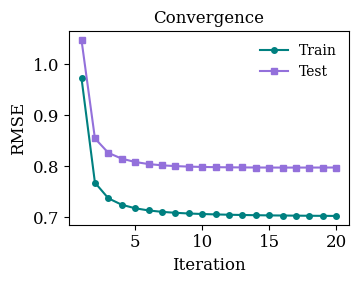

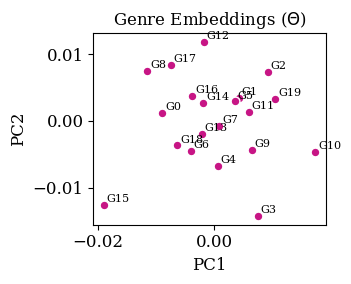

In [ ]:
# Convergence plot
plt.figure()
plt.plot(range(1, len(t_rmse)+1), t_rmse, label="Train", marker='o', color='#008080', markersize=4)
plt.plot(range(1, len(v_rmse)+1), v_rmse, label="Test", marker='s', color='#9370DB', markersize=4)
plt.title("Convergence", fontsize=12)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend(frameon=False, fontsize=10)
finalize_plot("prac5_convergence_final")

# Visualize genre relationships
pca = PCA(n_components=2)
theta_2d = pca.fit_transform(theta)

plt.figure()
plt.scatter(theta_2d[:, 0], theta_2d[:, 1], color='#C71585', edgecolors='white', s=40)
for i in range(num_genres):
    plt.annotate(f"G{i}", (theta_2d[i, 0], theta_2d[i, 1]),
                 xytext=(2, 2), textcoords='offset points', fontsize=8, family='serif')

plt.title("Genre Embeddings ($\Theta$)", fontsize=12)
plt.xlabel("PC1")
plt.ylabel("PC2")
finalize_plot("prac5_genre_embeddings_final")